In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline

In [2]:
ROOT = Path('../..')

SRC_FILE = ROOT / 'data/raw/lfs_by_pcon.csv'
OUT_FILE = ROOT / 'data/processed/labour-market/most_recent_by_pcon.csv'
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)

Load the latest CSV. This is downloaded by the 'download-from-nomis-api.py' script.

In [3]:
data = pd.read_csv(
    SRC_FILE,
    parse_dates=['DATE'],
    usecols=['DATE', 'DATE_NAME', 'GEOGRAPHY_CODE', 'GEOGRAPHY_NAME', 'GEOGRAPHY_TYPE', 'VARIABLE_CODE', 'VARIABLE_NAME', 'MEASURES_NAME', 'OBS_VALUE', 'OBS_STATUS_NAME']
)

Convert the column names to lower case.

In [4]:
data.columns = data.columns.str.lower()

Tidy up the `variable_name` column

In [5]:
data.variable_name = data.variable_name.str.strip()

Rename the `obs_value` column to `value`.

In [6]:
data = data.rename(
    columns={
      'obs_value': 'value',
      'obs_status_name': 'notes'
    }
)

Filter out only the **Variable** measures. The dataset also provides other measures such as **Numerator**, **Denominator** and **Confidence**

In [7]:
data = data.loc[ data.measures_name == 'Variable' ].drop(columns='measures_name')

Check missing data

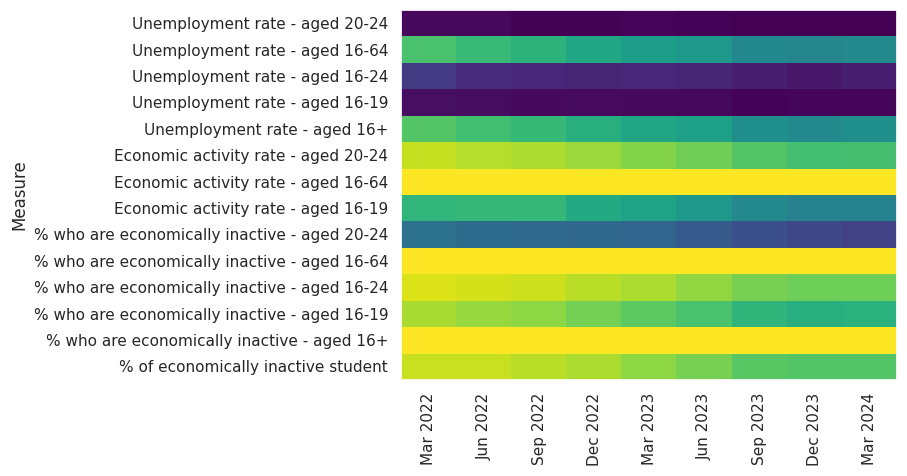

In [8]:
def visualise_coverage():
    plt.imshow(coverage, origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
    plt.grid(None)
    plt.ylabel('Measure')
    plt.yticks(ticks=range(len(coverage.index)), labels=coverage.index)
    plt.xticks(ticks=range(len(coverage.columns)), labels=coverage.columns.to_series().dt.strftime('%b %Y'), rotation=90, horizontalalignment='center')

counts = pd.DataFrame({
  'available': data.groupby(['date', 'variable_name']).value.count(),
  'total': data.groupby(['date', 'variable_name']).value.size()
})
coverage = pd.Series(
  counts.available / counts.total, name='coverage'
).reset_index().pivot(
  index='variable_name', columns='date', values='coverage'
)

visualise_coverage()

Get the most recently published data per area, to increase coverage

In [9]:
def get_latest_available(data):
  # Calculate dates
  failsafe_date = data.date.min() - pd.Timedelta("1 days")
  latest_date = data.date.max()
  # Subset the input data
  test_data = data.loc[:, ['geography_code', 'date', 'variable_name', 'value']]
  # Construct a failsafe (to be used in the event that there is no data available)
  # This will have the same index as the most recent values, which we use below...
  failsafe_data = test_data.loc[test_data.date == latest_date]
  failsafe_data.loc[:, ['date', 'value']] = (failsafe_date, -1)
  # Concatenate the test and failsafe_data
  test_data = pd.concat([ test_data, failsafe_data ]).sort_values('date', ascending=True)
  # Get the indexes for the non-zero values
  indexes = test_data.dropna(subset='value').groupby(['geography_code', 'variable_name'])['date'].idxmax()
  return data.loc[indexes]

latest_available = get_latest_available(data)

In [10]:
latest = data.loc[data.date == data.date.max()].groupby(['variable_name']).value
patched = latest_available.groupby(['variable_name']).value
coverage = pd.DataFrame({
  'latest coverage': latest.count() / latest.size() * 100,
  'patched coverage': patched.count() / patched.size() * 100,
})

coverage

,latest coverage,patched coverage
variable_name,,
% of economically inactive student,72.620905,97.337510
% who are economically inactive - aged 16+,98.595944,98.590446
% who are economically inactive - aged 16-19,63.572543,96.226415
% who are economically inactive - aged 16-24,77.301092,98.042287
% who are economically inactive - aged 16-64,98.283931,98.590446
% who are economically inactive - aged 20-24,20.436817,58.653093
Economic activity rate - aged 16-19,44.539782,86.296006
Economic activity rate - aged 16-64,98.595944,98.590446
Economic activity rate - aged 20-24,69.734789,97.102584


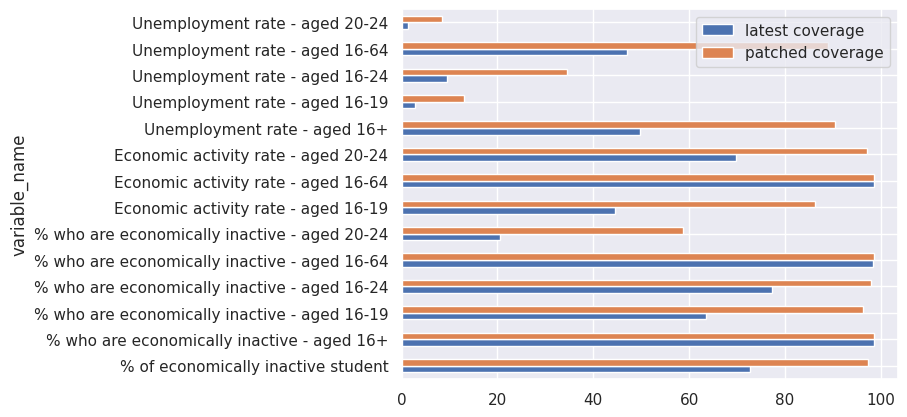

In [11]:
ax = coverage.plot.barh()

Save the data by parliamentary constituency to a csv

In [12]:
latest_available.loc[
    data.geography_type
        .isin([
          'parliamentary constituencies 2010',
          'Westminster Parliamentary Constituencies (July 2024)'
        ])
    ].drop(columns=['geography_type']).to_csv(OUT_FILE, index=False)